In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
import os, time
from tqdm import tqdm
import torch.nn as nn
from collections import OrderedDict
from sklearn.preprocessing import LabelBinarizer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation = True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))
    def forward(self, x):
        return self.mlp(x)
    
class Encoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Encoder, self).__init__()
        c, h, w = shape
        ww = ((w-8)//2 - 4)//2
        hh = ((h-8)//2 - 4)//2
        self.encode = nn.Sequential(nn.Conv2d(c, 16, 5, padding = 0), nn.BatchNorm2d(16), nn.ReLU(inplace = True), 
                                    nn.Conv2d(16, 32, 5, padding = 0), nn.BatchNorm2d(32), nn.ReLU(inplace = True), 
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(32, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True), 
                                    nn.Conv2d(64, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True), 
                                    nn.MaxPool2d(2, 2),
                                    Flatten(), MLP([ww*hh*64, 256, 128])
                                   )
        self.calc_mean = MLP([128+ncond, 64, nhid], last_activation = False)
        self.calc_logvar = MLP([128+ncond, 64, nhid], last_activation = False)
    def forward(self, x, y = None):
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            return self.calc_mean(torch.cat((x, y), dim=1)), self.calc_logvar(torch.cat((x, y), dim=1))

class Decoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Decoder, self).__init__()
        c, w, h = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid+ncond, 64, 128, 256, c*w*h], last_activation = False), nn.Sigmoid())
    def forward(self, z, y = None):
        c, w, h = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w, h)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w, h)

class VAE(nn.Module):
    def __init__(self, shape, nhid = 16):
        super(VAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid)
        self.decoder = Decoder(shape, nhid)
        
    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.sampling(mean, logvar)
        return self.decoder(z), mean, logvar
    
    def generate(self, batch_size = None):
        z = torch.randn((batch_size, self.dim)).to(device) if batch_size else torch.randn((1, self.dim)).to(device)
        res = self.decoder(z)
        if not batch_size:
            res = res.squeeze(0)
        return res

class cVAE(nn.Module):
    def __init__(self, shape, nclass, nhid = 16, ncond = 16):
        super(cVAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid, ncond = ncond)
        self.decoder = Decoder(shape, nhid, ncond = ncond)
        self.label_embedding = nn.Embedding(nclass, ncond)
        
    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma
    
    def forward(self, x, y):
        y = self.label_embedding(y)
        mean, logvar = self.encoder(x, y)
        z = self.sampling(mean, logvar)
        return self.decoder(z, y), mean, logvar
    
    def generate(self, class_idx):
        if (type(class_idx) is int):
            class_idx = torch.tensor(class_idx)
        class_idx = class_idx.to(device)
        if (len(class_idx.shape) == 0):
            batch_size = None
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device) 
        y = self.label_embedding(class_idx)
        res = self.decoder(z, y)
        if not batch_size:
            res = res.squeeze(0)
        return res
        
BCE_loss = nn.BCELoss(reduction = "sum")
def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KL_divergence

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.1)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.1)

def crop(x, low, high):
    x[x<=low] = low
    x[x>=high] = high
    return x

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def plot_images(image, num_images=6, size=(1, 28, 28)):
    image_grid = make_grid(image.detach().cpu()[:num_images], nrow=3)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.))
])

train_data = torchvision.datasets.MNIST(root='../../Datasets', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='../../Datasets', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../Datasets/MNIST/raw



In [6]:
vae = VAE((1, 28, 28), nhid = 4)
vae.apply(weights_init)
vae.to(device)
batch_size = 64
optimizer = torch.optim.Adam(vae.parameters(), lr= 0.001, weight_decay = 0.001)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 938/938 [00:15<00:00, 58.67it/s]


epoch 0, train loss 7467.217102441198


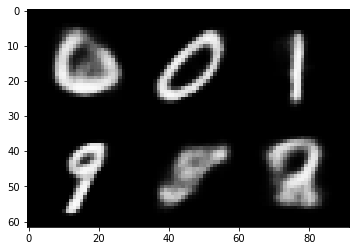

100%|██████████| 938/938 [00:16<00:00, 58.33it/s]


epoch 1, train loss 7390.725327741871


100%|██████████| 938/938 [00:15<00:00, 58.98it/s]


epoch 2, train loss 7315.173134224247


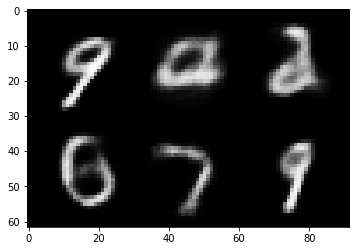

100%|██████████| 938/938 [00:15<00:00, 58.96it/s]


epoch 3, train loss 7257.905468906167


100%|██████████| 938/938 [00:16<00:00, 58.24it/s]


epoch 4, train loss 7207.830248086438


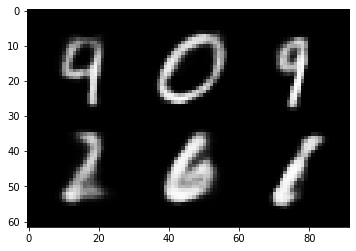

100%|██████████| 938/938 [00:16<00:00, 58.07it/s]


epoch 5, train loss 7159.413414928705


100%|██████████| 938/938 [00:15<00:00, 59.12it/s]


epoch 6, train loss 7137.371855322995


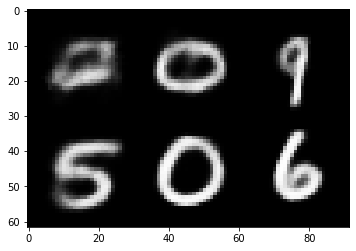

100%|██████████| 938/938 [00:16<00:00, 58.50it/s]


epoch 7, train loss 7091.806831408665


100%|██████████| 938/938 [00:16<00:00, 58.44it/s]


epoch 8, train loss 7072.423618341051


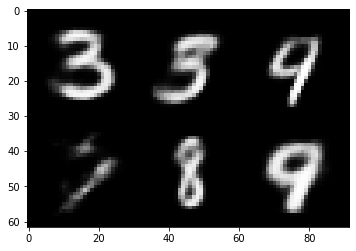

100%|██████████| 938/938 [00:16<00:00, 57.09it/s]

epoch 9, train loss 7040.429527949676


In [8]:
n_epochs = 10
frequency = 2
for epoch in range(n_epochs):
    train_loss= []
    for x,y in tqdm(train_loader):
        x = x.to(device)
        x = (x>0.5).float()
        optimizer.zero_grad()
        x_hat, mean, logvar = vae(x)
        kl_bce_loss = loss(x, x_hat, mean, logvar).to(device)
        kl_bce_loss.backward()
        optimizer.step()

        train_loss += [kl_bce_loss.item()]
    print(f'epoch {epoch}, train loss {np.mean(train_loss)}')

    if epoch % frequency ==0:
      plot_images(vae.generate(20))

In [10]:
frequency = 4


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = cVAE((1, 28, 28), 10, nhid = 2, ncond = 16)
net.to(device)
print(net)

lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate


max_epochs = 3
net = net.to(device)

print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm(train_loader, ncols = 50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))
    
    adjust_lr(optimizer)

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

100%|███████████| 938/938 [00:16<00:00, 57.74it/s]


epoch 0, train loss 144.2948 , time 16.2 sec


100%|███████████| 938/938 [00:16<00:00, 57.67it/s]


epoch 1, train loss 135.8998 , time 16.3 sec


100%|███████████| 938/938 [00:16<00:00, 57.52it/s]

epoch 2, train loss 134.2012 , time 16.3 sec
